# vitalPeriodic

"Periodic" data refers to data which is consistently interfaced from bedside vital signs monitors into eCareManager. Data are generally interfaced as 1 minute averages, and archived into the vitalPeriodic table as 5 minute median values.

The vital signs are **not** validated by care staff, so data quality can vary, but the use of 1 minute averages followed by 5 minute medians before archival removes many spurious readings.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [6]:
patientunitstayid = 145467

In [7]:
query = query_schema + """
select *
from vitalperiodic
where patientunitstayid = {}
order by observationoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,patientunitstayid,vitalperiodicid,observationyear,observationtime24,observationtime,observationoffset,temperature,sao2,heartrate,respiration,...,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
0,145467,40613790,2014,19:37:00,night,8,NaN,100.0,66.0,9.0,...,110.0,54.0,71.0,31.0,11.0,18.0,-0.4,0.0,0.2,None
1,145467,40613624,2014,19:42:00,night,13,NaN,100.0,65.0,19.0,...,106.0,53.0,69.0,34.0,17.0,24.0,-0.5,-0.1,0.2,None
2,145467,40613458,2014,19:47:00,night,18,NaN,100.0,69.0,32.0,...,96.0,50.0,65.0,47.0,16.0,23.0,-0.5,-0.1,0.2,None
3,145467,40613292,2014,19:52:00,night,23,NaN,100.0,71.0,7.0,...,111.0,57.0,74.0,36.0,16.0,23.0,-0.4,-0.1,0.1,None
4,145467,40613127,2014,19:57:00,night,28,36.8,100.0,72.0,15.0,...,111.0,59.0,75.0,36.0,18.0,25.0,-0.4,-0.1,0.2,None


In [8]:
df.columns

Index(['patientunitstayid', 'vitalperiodicid', 'observationyear',
       'observationtime24', 'observationtime', 'observationoffset',
       'temperature', 'sao2', 'heartrate', 'respiration', 'cvp', 'etco2',
       'systemicsystolic', 'systemicdiastolic', 'systemicmean', 'pasystolic',
       'padiastolic', 'pamean', 'st1', 'st2', 'st3', 'icp'],
      dtype='object')

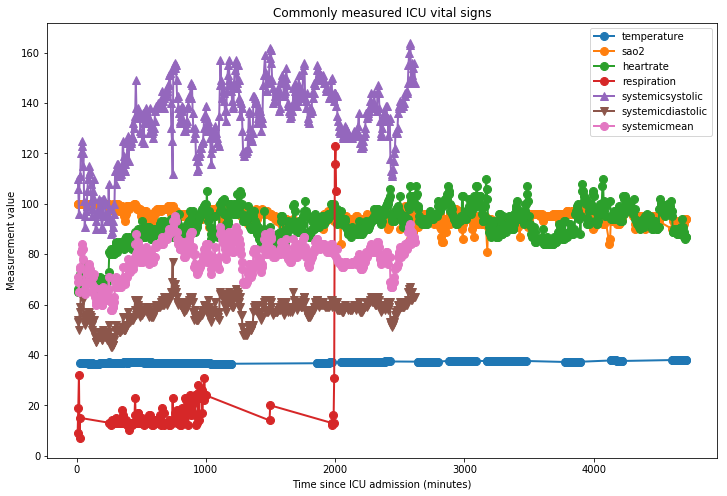

In [10]:
# list of columns to plot
vitals = ['temperature', 'sao2', 'heartrate', 'respiration',
          'systemicsystolic', 'systemicdiastolic', 'systemicmean']

plt.figure(figsize=[12,8])
for v in vitals:
    df_plot = df[['observationoffset', v]].dropna()
    if 'systolic' in v:
        marker = '^-'
    elif 'diastolic' in v:
        marker = 'v-'
    else:
        marker = 'o-'
        
    plt.plot(df_plot['observationoffset'],
             pd.to_numeric(df_plot[v], errors='coerce'),
            marker, markersize=8, lw=2, label=v)
    
plt.xlabel('Time since ICU admission (minutes)')
plt.ylabel('Measurement value')
plt.legend(loc='upper right')
plt.title('Commonly measured ICU vital signs')
plt.show()

As we can see most data is fairly consistent but there are a few clear outliers for respiration likely due to artifacts around the 2000 minute mark.

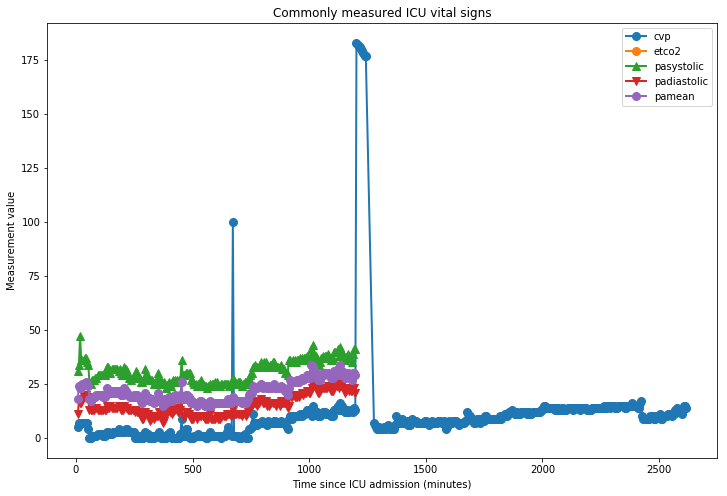

In [12]:
# list of columns to plot
vitals = ['cvp', 'etco2',
         'pasystolic', 'padiastolic', 'pamean']

plt.figure(figsize=[12,8])
for v in vitals:
    df_plot = df[['observationoffset', v]].dropna()
    if 'systolic' in v:
        marker = '^-'
    elif 'diastolic' in v:
        marker = 'v-'
    else:
        marker = 'o-'
        
    plt.plot(df_plot['observationoffset'],
             pd.to_numeric(df_plot[v], errors='coerce'),
            marker, markersize=8, lw=2, label=v)
    
plt.xlabel('Time since ICU admission (minutes)')
plt.ylabel('Measurement value')
plt.legend(loc='upper right')
plt.title('Commonly measured ICU vital signs')
plt.show()

Though rare, this patient appears to have pulmonary artery monitoring which ceases at around the 1200 minute mark. This also coincides with a large increase in measured central venous pressure (CVP), which is probably related to the catheter removal.

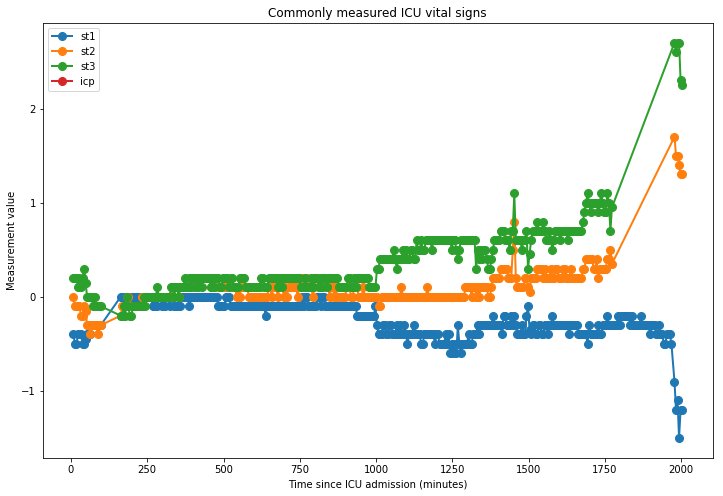

In [14]:
# list of columns to plot
vitals = ['st1', 'st2', 'st3', 'icp']

plt.figure(figsize=[12,8])
for v in vitals:
    df_plot = df[['observationoffset', v]].dropna()
    if 'systolic' in v:
        marker = '^-'
    elif 'diastolic' in v:
        marker = 'v-'
    else:
        marker = 'o-'
        
    plt.plot(df_plot['observationoffset'],
             pd.to_numeric(df_plot[v], errors='coerce'),
            marker, markersize=8, lw=2, label=v)
    
plt.xlabel('Time since ICU admission (minutes)')
plt.ylabel('Measurement value')
plt.legend(loc='upper left')
plt.title('Commonly measured ICU vital signs')
plt.show()

Machine derived ST segment levels are also available - quantization of the value is done at 0.1 mV and is readily observable.

## Hospitals with data available

In [15]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from vitalperiodic
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6905,97.818388
54,167,6092,5763,94.599475
106,264,5237,5083,97.059385
184,420,4679,4462,95.362257
134,338,4277,4202,98.246434
58,176,4328,4142,95.702403
90,243,4243,4121,97.124676
71,199,4240,3941,92.948113
206,458,3701,3644,98.459876
80,208,3650,3611,98.931507


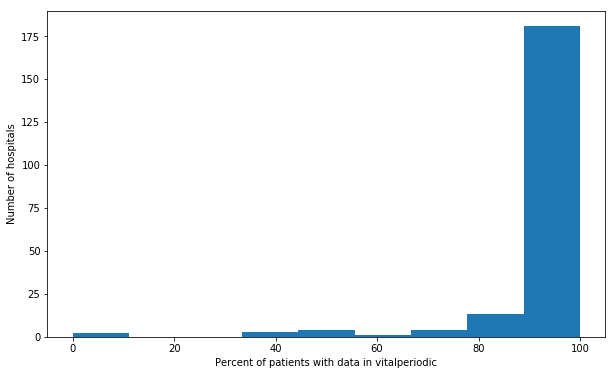

In [16]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in vitalperiodic')
plt.ylabel('Number of hospitals')
plt.show()

Most hospitals in eICU have good data coverage for the vitalperiodic table.